In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:\\Users\\ASUS\\Desktop\\AI Project\\Spam Calls SPIT\\icaller-data\\icaller_data_Long\\clean\\icaller_data_test.csv")
df['callto_callin'] = df.call_to/(df.call_in+0.00000001)
del df['call_to']
del df['call_in']
del df['call_to_miss']
del df['call_in_miss']
del df['duration_call_to']
del df['duration_call_in']
del df['in_hour']
df = df.rename(index=str, columns={"cung_mang": "same_network_operator"})
df

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,Spam,callto_callin
0,842473000991,47.199056,0.000000,0.000000,0.400000,0,1,2.000000e+08
1,842499950216,0.000000,32.777414,0.009615,0.067308,2,1,1.111111e-01
2,842499959998,8.361436,0.000000,0.000000,0.802326,0,1,8.100000e+09
3,842835214389,23.204493,0.000000,0.000000,0.250000,0,1,1.500000e+09
4,842838664080,3.794869,46.748831,0.041322,0.132231,57,1,1.400000e+01
...,...,...,...,...,...,...,...,...
2525,84869607598,5.249869,10.641293,0.031250,0.260417,75,0,8.695652e-02
2526,84903018040,7.749806,20.405350,0.658537,0.682927,18,0,8.823529e-02
2527,84966699609,26.571353,51.593589,0.179104,0.850746,60,0,8.750000e-01
2528,84392823504,51.156090,15.257553,0.846939,0.438776,57,0,8.400000e-01


# Normal

In [3]:
# for feature in df.columns[1:-1]:
#     df[feature]=df[feature].apply(np.log1p)

In [4]:
features=['phone','avg_duration_call_to','avg_duration_call_in','avg_in_contact','avg_success','same_network_operator','callto_callin','Spam']
df = df[features]

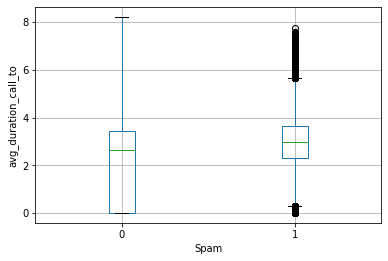

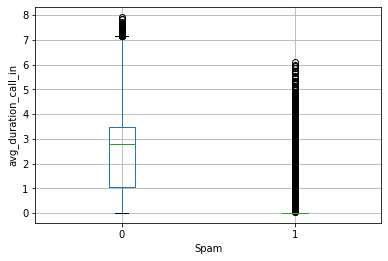

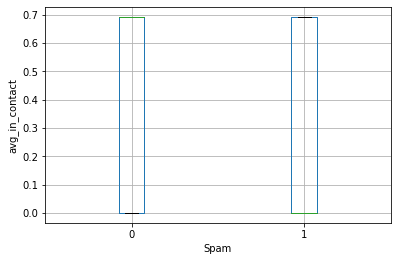

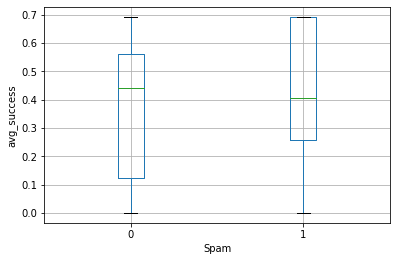

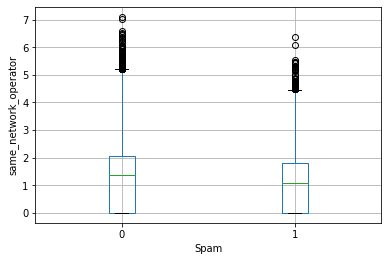

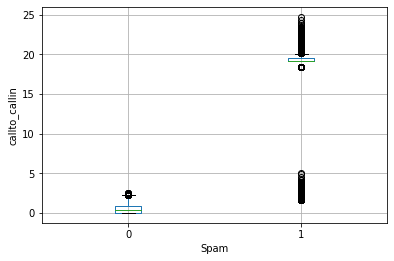

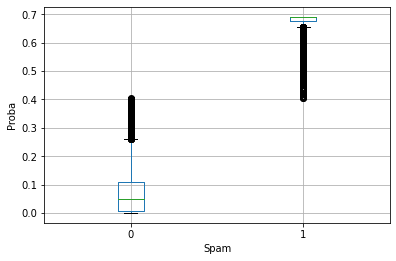

In [43]:
col= stick_label.columns.tolist()[1:-1]
for i in range(0 , len(col)) :
    ax = stick_label.boxplot(column= col[i], by='Spam')
    ax.set_ylabel(col[i])
    plt.suptitle('') # Suppress the titles
    plt.title('')
    plt.savefig(col[i]+'.png')

In [5]:

X = df.drop(columns=['phone','Spam'])
y = df['Spam']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

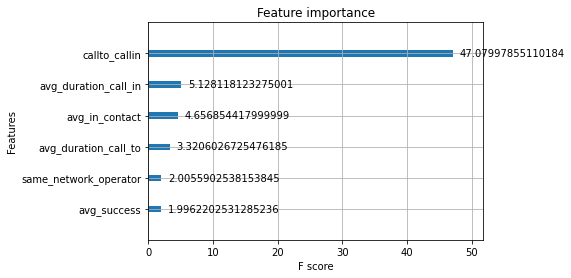

In [6]:
from xgboost import XGBClassifier
from xgboost import plot_importance
# fit model no training data
XGB = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)
XGB.fit(X, y)
# plot feature importance
plot_importance(XGB,importance_type = 'gain')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort


X = df.drop(columns=['phone','Spam'])
Y = df['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,  random_state=3)

# fit model on all training data
XGB = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)
XGB.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = XGB.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(XGB.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(XGB, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 98.68%
Thresh=0.026, n=6, Accuracy: 98.68%
Thresh=0.026, n=5, Accuracy: 98.55%
Thresh=0.032, n=4, Accuracy: 98.42%
Thresh=0.035, n=3, Accuracy: 98.55%
Thresh=0.054, n=2, Accuracy: 98.29%
Thresh=0.828, n=1, Accuracy: 98.29%


In [8]:
from numpy import mean
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


XGB = xgb.XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)
# define model
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(XGB, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.99849


In [9]:
df.groupby(['Spam']).count()

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,callto_callin
Spam,,,,,,,
0,2300,2300,2300,2300,2300,2300,2300
1,230,230,230,230,230,230,230


In [10]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['phone','Spam'])
Y = df['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,  random_state=3)
print(X_train.shape, y_train.shape)

#Clean outlier
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]
print(X_train.shape, y_train.shape)

(1771, 6) (1771,)
(1594, 6) (1594,)


In [11]:
# from imblearn.over_sampling import SVMSMOTE, SMOTE

# # oversample = SVMSMOTE(m_neighbors=20,k_neighbors=20)
# oversample = SMOTE(k_neighbors=20)
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# # t=Xt
# # t['Spam']=yt

In [12]:
features=['avg_duration_call_to','avg_duration_call_in','avg_in_contact','avg_success','same_network_operator','callto_callin']
X_train =  pd.DataFrame( X_train , columns=features )
y_train =  pd.DataFrame( y_train , columns=['Spam'] )
len(y_train)

1594

-------------------------------------XGBClassifier----------------------------------------------------------
[0]	validation_0-logloss:0.600068	validation_1-logloss:0.603104
[1]	validation_0-logloss:0.523582	validation_1-logloss:0.528751
[2]	validation_0-logloss:0.460024	validation_1-logloss:0.467252
[3]	validation_0-logloss:0.406038	validation_1-logloss:0.415053
[4]	validation_0-logloss:0.359934	validation_1-logloss:0.370621
[5]	validation_0-logloss:0.320198	validation_1-logloss:0.3325
[6]	validation_0-logloss:0.285348	validation_1-logloss:0.299149
[7]	validation_0-logloss:0.25494	validation_1-logloss:0.270175
[8]	validation_0-logloss:0.228608	validation_1-logloss:0.245193
[9]	validation_0-logloss:0.205113	validation_1-logloss:0.223002
[10]	validation_0-logloss:0.184369	validation_1-logloss:0.203515
[11]	validation_0-logloss:0.166081	validation_1-logloss:0.186013
[12]	validation_0-logloss:0.149766	validation_1-logloss:0.17086
[13]	validation_0-logloss:0.135257	validation_1-logloss:0.15

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


 0.984375

 confussion matrix:
 [[684   1]
 [ 11  63]]


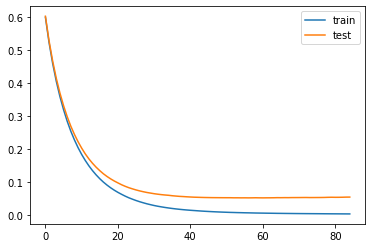

In [13]:
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
def KQ(y_test,prediction_train,prediction_test):
    print('Accuracy_train:', accuracy_score(y_train, prediction_train))
    print('Accuracy_test:', accuracy_score(y_test, prediction_test))
    print('F1 score:', f1_score(y_test, prediction_test))
    print('Recall:', recall_score(y_test, prediction_test))
    print('Precision:', precision_score(y_test, prediction_test))
   # print('\n clasification report:\n', classification_report(y_test,prediction))
    print('\n confussion matrix:\n',confusion_matrix(y_test, prediction_test))
# print(len(df_non))
Score = []
F1_score = []
Recall = []
Precision =  []

# XGBClassifier
print('-------------------------------------XGBClassifier----------------------------------------------------------')
import xgboost as xgb
XGB = xgb.XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]
# fit the model
XGB.fit(X_train, y_train , eval_metric='logloss', eval_set=evalset)


prediction_train = XGB.predict(X_train)
prediction_test =XGB.predict(X_test)

predict_proba = XGB.predict_proba(X_test)


KQ(y_test,prediction_train,prediction_test)
Score.append(accuracy_score(y_test, prediction_test))
F1_score.append(f1_score(y_test, prediction_test))
Recall.append(recall_score(y_test, prediction_test))
Precision.append(precision_score(y_test, prediction_test))

# retrieve performance metrics
results = XGB.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

Best Threshold=0.008648


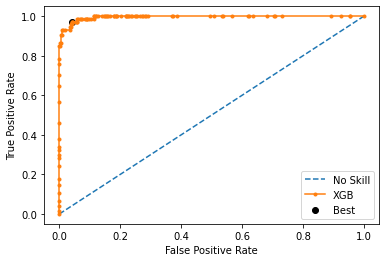

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from math import sqrt
from sklearn.metrics import precision_recall_curve
proba = predict_proba[:,1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, proba)
# calculate the g-mean for each threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGB')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()
#0.188469

Best Threshold=0.098722, F-Score=0.932


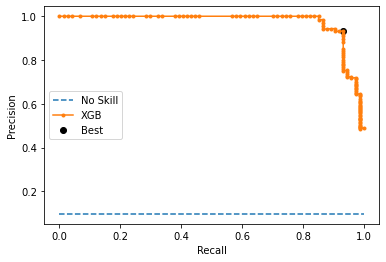

In [15]:
from numpy import arange
from numpy import argmax
from sklearn.metrics import roc_curve, roc_auc_score
from math import sqrt
from sklearn.metrics import precision_recall_curve

proba = predict_proba[:,1]


# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, proba)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGB')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [16]:
from numpy import arange
from numpy import argmax
from sklearn.metrics import roc_curve, roc_auc_score
from math import sqrt
from sklearn.metrics import precision_recall_curve

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


proba = predict_proba[:,1]

# define thresholds
thresholds = arange(0, 1, 0.001)


# evaluate each threshold
scores = [f1_score(y_test, to_labels(proba, t)) for t in thresholds]
# evaluate each threshold
scores = [f1_score(y_test, to_labels(proba, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.094, F-Score=0.93243


Random (chance) Prediction: AUROC = 0.500
XGB
             : AUROC = 0.996


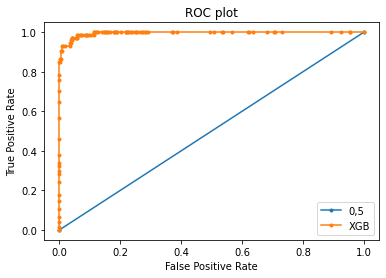

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
classifiers = [ XGB ]
classifiers_name = [ 'XGB' ]
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs )
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
plt.plot(r_fpr, r_tpr, marker='.', label = '0,5' % (r_auc))
AUC_clean = []
for i in range(len(classifiers_name)):
    i_probs = classifiers[i].predict_proba(X_test)
    i_probs = i_probs[:,1]
    i_auc = roc_auc_score(y_test, i_probs)
    i_fpr, i_tpr, _ = roc_curve(y_test, i_probs )
    print(classifiers_name[i])
    print('             : AUROC = %.3f' % (i_auc))
    AUC_clean.append(i_auc)
    plt.plot(i_fpr, i_tpr, marker='.', label = classifiers_name[i] % (i_auc))
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


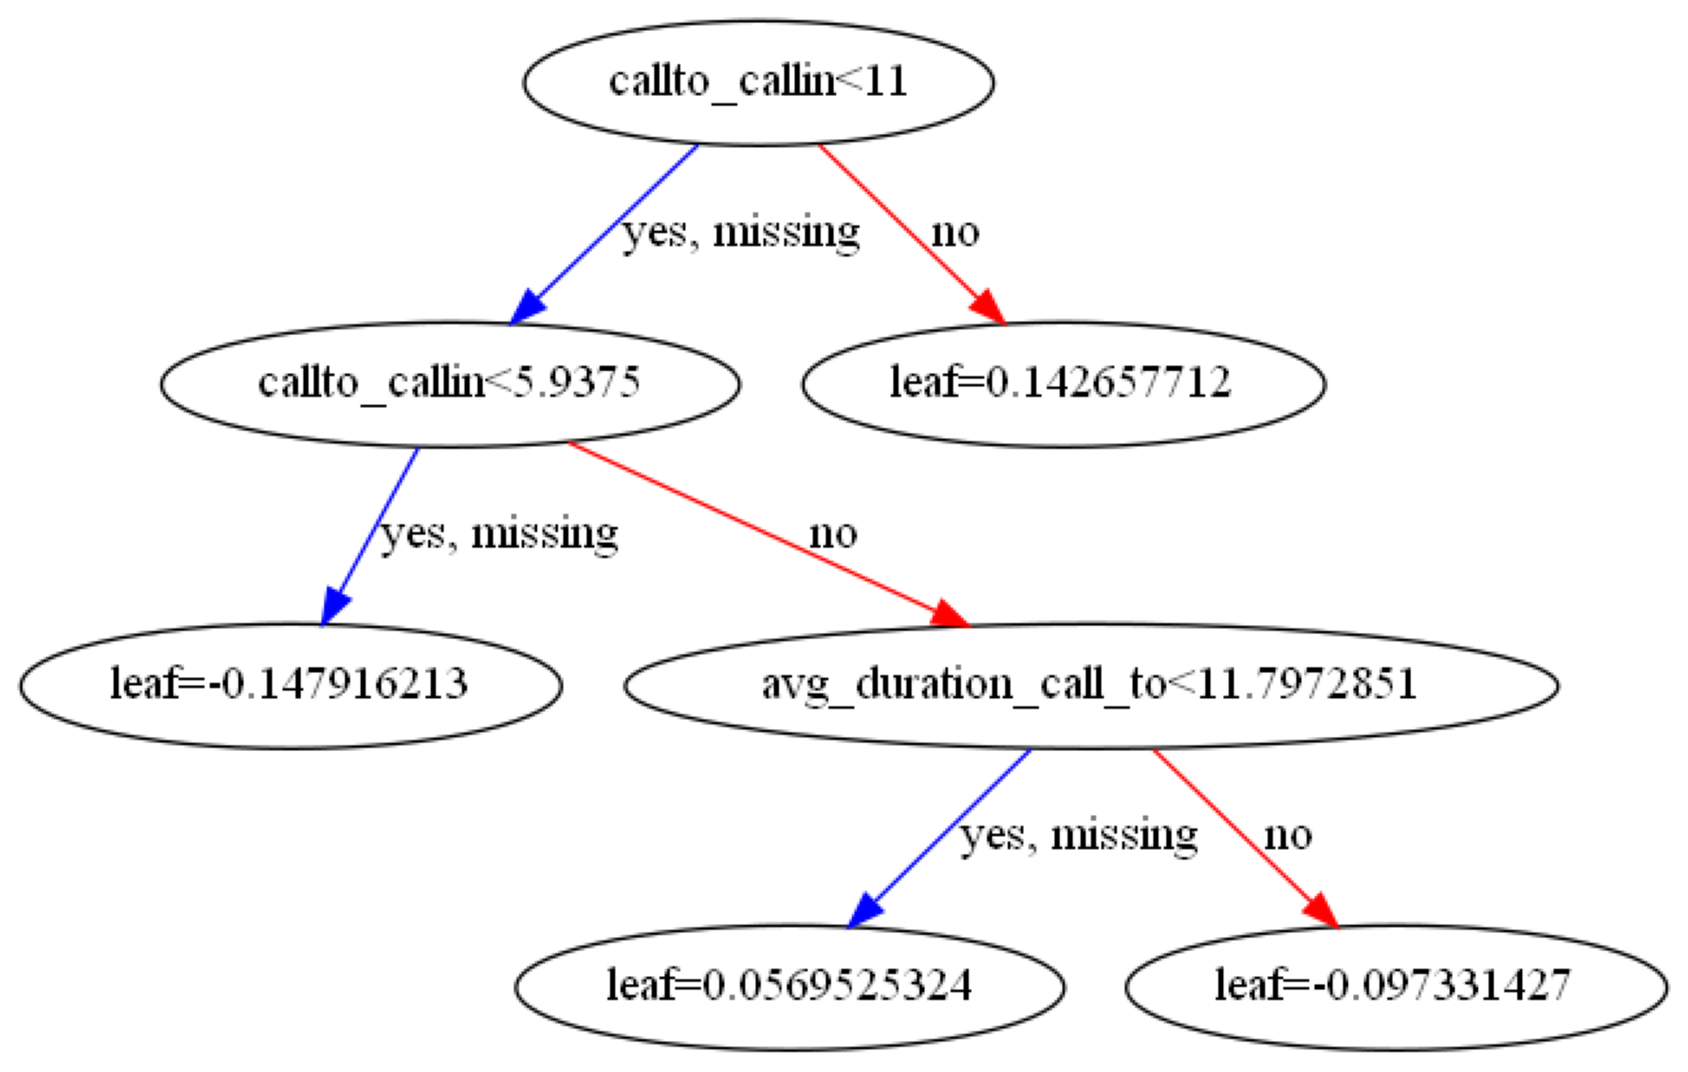

In [42]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax,num_trees=4)
plt.savefig('tree.png')
plt.show()
# plot_tree(XGB,num_trees=0, rankdir='LR')

# plt.show()
                       

# Non label

In [19]:
notlabel = pd.read_csv("C:\\Users\\ASUS\\Desktop\\AI Project\\Spam Calls SPIT\\icaller-data\\icaller_data_Long\\clean\\notlabel_clean_new.csv")
notlabel

,phone,call_to,call_in,call_to_miss,call_in_miss,duration_call_to,duration_call_in,avg_duration_call_to,avg_duration_call_in,avg_in_contact,in_hour,avg_success,cung_mang,Spam
0,842437710404,1,2,0,0,75.0,215.0,74.992501,107.494625,0.000000,3,1.000000,0,0
1,842437824654,2,0,0,0,7.0,0.0,3.499825,0.000000,1.000000,1,0.000000,0,0
2,842437835527,3,1,0,1,120.0,26.0,39.998667,12.999350,0.000000,5,0.800000,0,0
3,842437836363,3,0,0,0,42.0,0.0,13.999533,0.000000,0.333333,3,1.000000,0,0
4,842437938828,3,1,0,0,185.0,12.0,61.664611,11.998800,0.000000,4,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167984,998995279591,4,6,0,0,563.0,1434.0,140.746481,238.996017,0.000000,6,1.000000,10,0
167985,998995720517,0,0,0,14,0.0,0.0,0.000000,0.000000,0.000000,0,0.000000,14,0
167986,999,10,0,24,38,179.0,0.0,5.264690,0.000000,0.027778,48,0.083333,1,0
167987,9999,0,0,0,2,0.0,0.0,0.000000,0.000000,0.000000,1,0.000000,0,0


In [20]:
notlabel['callto_callin'] = notlabel.call_to/(notlabel.call_in+0.00000001)

del notlabel['call_to']
del notlabel['call_in']
del notlabel['call_to_miss']
del notlabel['call_in_miss']
del notlabel['duration_call_to']
del notlabel['duration_call_in']
del notlabel['in_hour']
notlabel = notlabel.rename(columns={"cung_mang": "same_network_operator"})
notlabel

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,Spam,callto_callin
0,842437710404,74.992501,107.494625,0.000000,1.000000,0,0,5.000000e-01
1,842437824654,3.499825,0.000000,1.000000,0.000000,0,0,2.000000e+08
2,842437835527,39.998667,12.999350,0.000000,0.800000,0,0,3.000000e+00
3,842437836363,13.999533,0.000000,0.333333,1.000000,0,0,3.000000e+08
4,842437938828,61.664611,11.998800,0.000000,1.000000,0,0,3.000000e+00
...,...,...,...,...,...,...,...,...
167984,998995279591,140.746481,238.996017,0.000000,1.000000,10,0,6.666667e-01
167985,998995720517,0.000000,0.000000,0.000000,0.000000,14,0,0.000000e+00
167986,999,5.264690,0.000000,0.027778,0.083333,1,0,1.000000e+09
167987,9999,0.000000,0.000000,0.000000,0.000000,0,0,0.000000e+00


# Normal

In [21]:
# for feature in notlabel.columns[1:-1]:
#     notlabel[feature]=notlabel[feature].apply(np.log1p)

In [22]:
P = notlabel['phone']
X = notlabel.drop(columns=['Spam','phone'])
Y = notlabel['Spam']

# stick the label

In [23]:
prediction_notlabel =XGB.predict(X)
predict_proba = XGB.predict_proba(X)
proba = predict_proba[:,1]
X['Spam'] = prediction_notlabel
X['Proba'] = proba
X

,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,callto_callin,Spam,Proba
0,74.992501,107.494625,0.000000,1.000000,0,5.000000e-01,0,0.006078
1,3.499825,0.000000,1.000000,0.000000,0,2.000000e+08,1,0.972047
2,39.998667,12.999350,0.000000,0.800000,0,3.000000e+00,0,0.008753
3,13.999533,0.000000,0.333333,1.000000,0,3.000000e+08,1,0.901278
4,61.664611,11.998800,0.000000,1.000000,0,3.000000e+00,0,0.008753
...,...,...,...,...,...,...,...,...
167984,140.746481,238.996017,0.000000,1.000000,10,6.666667e-01,0,0.003699
167985,0.000000,0.000000,0.000000,0.000000,14,0.000000e+00,0,0.007953
167986,5.264690,0.000000,0.027778,0.083333,1,1.000000e+09,1,0.928050
167987,0.000000,0.000000,0.000000,0.000000,0,0.000000e+00,0,0.008319


In [24]:
X.loc[X.Proba > 0.95]

,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,callto_callin,Spam,Proba
1,3.499825,0.0,1.0,0.000000,0,200000000.0,1,0.972047
6,87.995600,0.0,0.0,1.000000,0,200000000.0,1,0.990485
7,163.994534,0.0,1.0,0.400000,0,200000000.0,1,0.959386
9,101.663278,0.0,0.0,1.000000,0,300000000.0,1,0.990485
10,3.333222,0.0,1.0,0.333333,0,100000000.0,1,0.969957
...,...,...,...,...,...,...,...,...
167944,10.999450,0.0,0.0,1.000000,0,200000000.0,1,0.994708
167964,85.330489,0.0,0.0,0.400000,5,200000000.0,1,0.990485
167973,3.599928,0.0,0.0,0.400000,0,200000000.0,1,0.994995
167976,27.498625,0.0,1.0,0.285714,7,200000000.0,1,0.962182


In [25]:
stick_label = pd.concat([P,X],axis=1)
stick_label.groupby(['Spam']).count()

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,callto_callin,Proba
Spam,,,,,,,,
0,116682,116682,116682,116682,116682,116682,116682,116682
1,51307,51307,51307,51307,51307,51307,51307,51307


In [26]:
features=['phone','avg_duration_call_to','avg_duration_call_in','avg_in_contact','avg_success','same_network_operator','callto_callin','Proba','Spam']
stick_label = stick_label[features]

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
for feature in stick_label.columns[1:-1]:
    stick_label[feature]=stick_label[feature].apply(np.log1p)

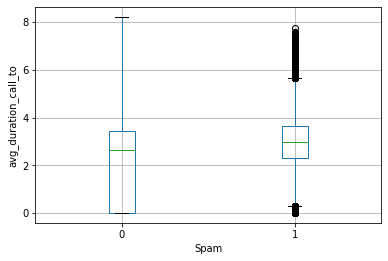

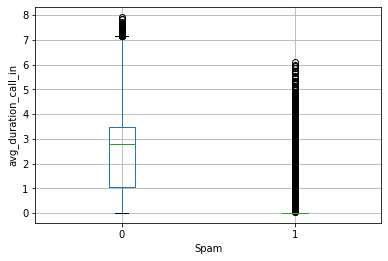

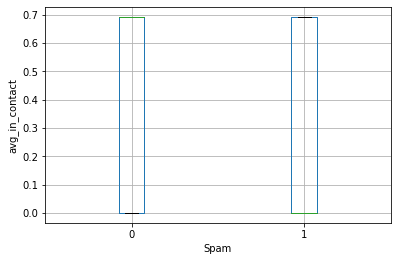

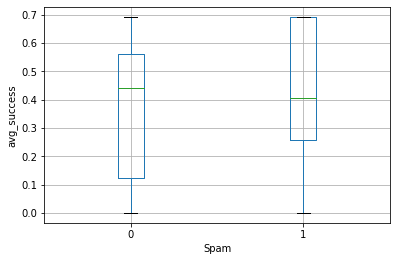

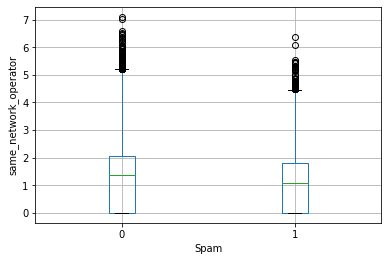

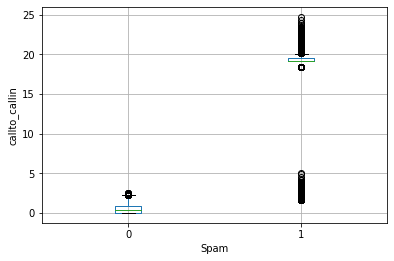

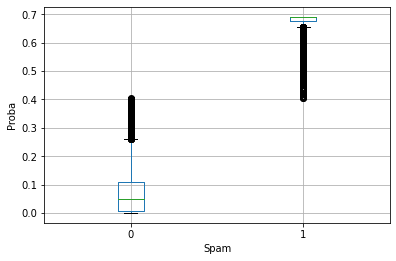

In [28]:
col= stick_label.columns.tolist()[1:-1]
for i in range(0 , len(col)) :
    ax = stick_label.boxplot(column= col[i], by='Spam')
    ax.set_ylabel(col[i])
    plt.suptitle('') # Suppress the titles
    plt.title('')
    plt.savefig(col[i]+'.png')

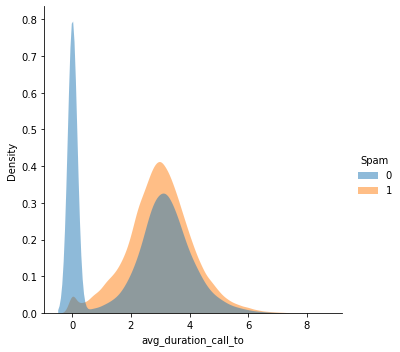

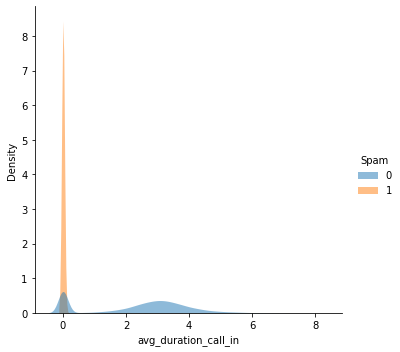

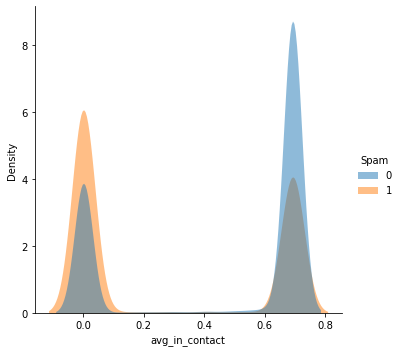

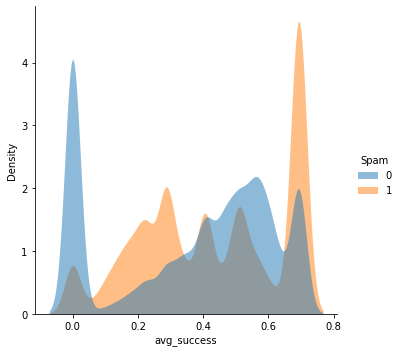

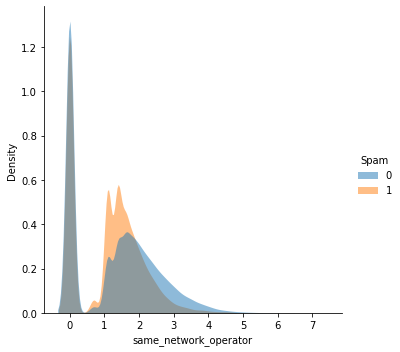

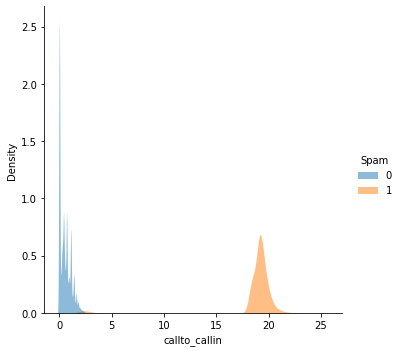

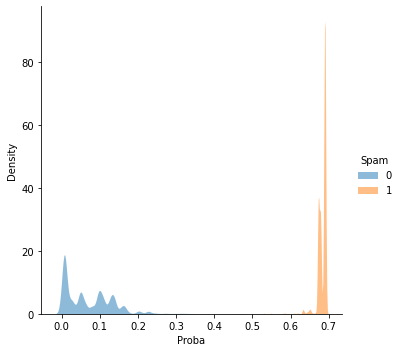

In [29]:
col= stick_label.columns.tolist()[1:-1]
for i in col :
   
    a = sns.displot(stick_label, x=i ,hue='Spam', kind="kde",fill=True, common_norm=False, palette="tab10", alpha=.5, linewidth=0,)
    a.savefig( i +' 6type_density.png')

In [30]:
spam = stick_label.loc[stick_label.Spam == 1]

In [31]:
spam.to_csv('spam_deploy.csv', index=False)

In [32]:
54874/4298161

0.012766855406300508

In [33]:
2198935

2198935

In [34]:
spam

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,same_network_operator,callto_callin,Proba,Spam
1,842437824654,1.504039,0.0,0.693147,0.000000,0.000000,19.113828,0.679072,1
3,842437836363,2.708019,0.0,0.287682,0.693147,0.000000,19.519293,0.642526,1
6,842437955798,4.488587,0.0,0.000000,0.693147,0.000000,19.113828,0.688379,1
7,842437959595,5.105912,0.0,0.693147,0.336472,0.000000,19.113828,0.672631,1
9,842438223650,4.631454,0.0,0.000000,0.693147,0.000000,19.519293,0.688379,1
...,...,...,...,...,...,...,...,...,...
167964,992556004865,4.458183,0.0,0.000000,0.336472,1.791759,19.113828,0.688379,1
167973,99877563,1.526041,0.0,0.000000,0.336472,0.000000,19.113828,0.690641,1
167976,998936204202,3.349856,0.0,0.693147,0.251314,2.079442,19.113828,0.674057,1
167980,998990144636,3.060239,0.0,0.693147,0.470004,1.791759,19.519293,0.679320,1
